In [1]:
### Import the required libraries
import numpy as np
import scipy
import matplotlib.pyplot as plt 

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter("ignore")

import tensorflow as tf
import tensorflow.keras as keras
tf.compat.v1.disable_eager_execution()

import os
from os.path import join
import sys

import xarray as xr
import xmitgcm
from xmitgcm import open_mdsdataset
import ecco_v4_py as ecco

# Append to sys.path the absolute path to src/XAIRT
path_list = os.path.abspath('').split('/')
path_src_XAIRT = ''
for link in path_list[:-1]:
    path_src_XAIRT = path_src_XAIRT+link+'/'
sys.path.append(path_src_XAIRT+'/src')

# Now import module XAIRT
from XAIRT import *

# See if GPUs are available
from keras import backend as K
if bool(K._get_available_gpus()):
    print("Running on GPU")
else:
    print("Running on CPU")

2023-09-19 01:19:16.984230: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Running on GPU


2023-09-19 01:19:23.722272: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38251 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0
2023-09-19 01:19:23.735595: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38251 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0
2023-09-19 01:19:23.737763: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38251 MB memory:  -> device: 2, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:e2:00.0, compute capability: 8.0


In [2]:
### Sverdrup 
# mainDir  = '/scratch2/pillarh/eccov4r4'
# gridDir  = mainDir + '/GRID'
# thetaDir = mainDir + '/eccov4r4_nctiles_daily/THETA'

### Lonestar6
mainDir  = '/work/07665/shrey911/ls6/LRP_eccov4r4_data'
gridDir  = mainDir
thetaDir = mainDir

In [3]:
# %%capture --no-stderr --no-stdout --no-display 

# #### https://stackoverflow.com/questions/72821108/hdf5-warnings-when-accessing-xarray-dataset
# #### Necessary to suppress stderr output that crashes the file
# from dask.distributed import Client
# c = Client(threads_per_worker=1)

# #### Write thetaSurf data year-wise to netcdf file in scracth2
# #### I did it manually one year at a time in list `years` since stderr output crashes the file

# def subset(ds):
#     dict_subset = {'k':0}
#     ds_subset = ds.isel(dict_subset); # ; at the end to suppress output
#     return ds_subset; # ; at the end to suppress output

# years = np.arange(1992,2018)

# # for year in years:
# #     ds = xr.open_mfdataset(join(thetaDir,f'{year}/*/*.nc'), preprocess=subset); # ; at the end to suppress output
# #     ds.to_netcdf(f'/scratch2/shreyas/LRP_eccov4r4_data/thetaSurfECCOv4r4_{year}.nc', mode='w')

# for year in years:
#     print(year)
#     ds = xr.open_mfdataset(join(saltDir,f'{year}/*/*.nc'), preprocess=subset); # ; at the end to suppress output
#     ds.to_netcdf(f'/scratch2/shreyas/LRP_eccov4r4_data/saltSurfECCOv4r4_{year}.nc', mode='w')

In [4]:
### Sverdrup  - /scratch2/shreyas/LRP_eccov4r4_data
### Lonestar6 - /work/07665/shrey911/ls6/LRP_eccov4r4_data

ds = xr.open_dataset(f'/work/07665/shrey911/ls6/LRP_eccov4r4_data/thetaSurfECCOv4r4.nc')
ds_salt = xr.open_dataset(f'/work/07665/shrey911/ls6/LRP_eccov4r4_data/saltSurfECCOv4r4.nc')

In [5]:
hFacC = ecco.read_llc_to_tiles(gridDir, 'hFacC.data')
hFacC_mask = hFacC > 0
hFacC_mask = hFacC_mask.astype(float)

XC = ds['XC'].data
YC = ds['YC'].data

latMask = YC > -20.0
latMask = latMask.astype(float)

maskFinal = hFacC_mask * latMask
NaNmaskFinal = np.copy(maskFinal)
NaNmaskFinal[NaNmaskFinal == 0] = np.nan

da_hFacC_mask = xr.DataArray(
    data=hFacC_mask,
    dims=["tile", "j", "i"],
    coords=dict(
        tile = ds['tile'].data,
        j    = ds['j'].data,
        i    = ds['i'].data,
    ),
    attrs=dict(description="hFacC mask 2D 1 if > 0, else 0"),
)

da_latMask = xr.DataArray(
    data=latMask,
    dims=["tile", "j", "i"],
    coords=dict(
        tile = ds['tile'].data,
        j    = ds['j'].data,
        i    = ds['i'].data,
    ),
    attrs=dict(description="Latitude Mask 1 if > -20, else 0"),
)

da_maskFinal = xr.DataArray(
    data=maskFinal,
    dims=["tile", "j", "i"],
    coords=dict(
        tile = ds['tile'].data,
        j    = ds['j'].data,
        i    = ds['i'].data,
    ),
    attrs=dict(description="Mask 2D 1 if > 0, else 0"),
)

da_NaNmaskFinal = xr.DataArray(
    data=NaNmaskFinal,
    dims=["tile", "j", "i"],
    coords=dict(
        tile = ds['tile'].data,
        j    = ds['j'].data,
        i    = ds['i'].data,
    ),
    attrs=dict(description="Mask 2D True if > 0, else NaN"),
)

ds = ds.assign(hFacC_mask   = da_hFacC_mask,
          latMask      = da_latMask,
          maskFinal    = da_maskFinal,
          NaNmaskFinal = da_NaNmaskFinal)

wetpoints = np.nonzero(ds['maskFinal'].data)

load_binary_array: loading file /work/07665/shrey911/ls6/LRP_eccov4r4_data/hFacC.data
load_binary_array: data array shape  (1170, 90)
load_binary_array: data array type  >f4
llc_compact_to_faces: dims, llc  (1170, 90) 90
llc_compact_to_faces: data_compact array type  >f4
llc_faces_to_tiles: data_tiles shape  (13, 90, 90)
llc_faces_to_tiles: data_tiles dtype  >f4


In [6]:
X_2d = ds['THETA'].transpose("time","j","i","tile").data

### X_2d is transposed, so order of wetpoint array changes, note in next line
X    = ds['THETA'].data[:,wetpoints[0],wetpoints[1],wetpoints[2]]
y    = ds['THETA'].isel(tile = 10, j = 1, i = 43).data

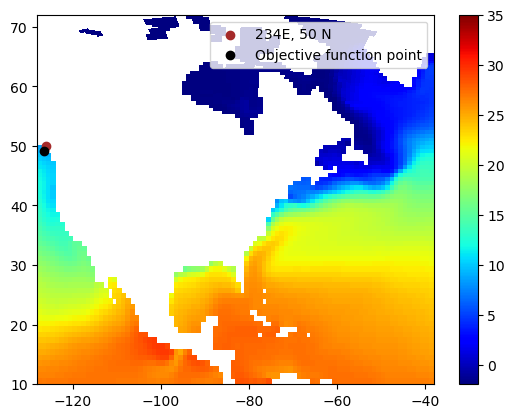

In [7]:
plt.pcolor(ds['XC'].isel(tile = 10), ds['YC'].isel(tile = 10), 
           ds['NaNmaskFinal'].isel(tile = 10)*ds['THETA'].isel(time = 0, tile = 10), 
           cmap = 'jet', vmax = 35)
plt.colorbar()
plt.scatter(-126.0, 50.0, color = 'brown', label = '234E, 50 N')
plt.scatter(ds['XC'].isel(tile = 10, j = 1, i = 43),
            ds['YC'].isel(tile = 10, j = 1, i = 43),
            color = 'black', label = 'Objective function point')
plt.legend()

Text(0.5, 1.0, 'MaskedTheta 1992_01_01')

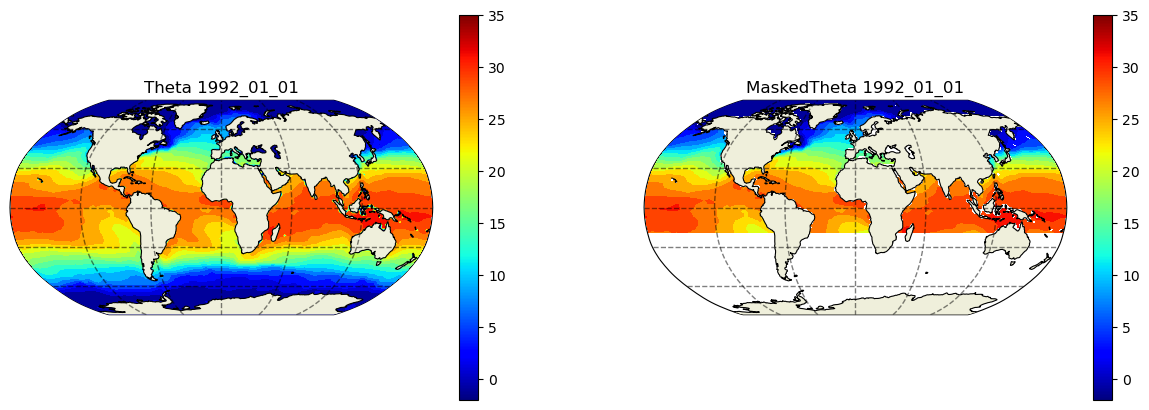

In [8]:
plt.figure(figsize=(15,5))

P = ecco.plot_proj_to_latlon_grid(ds['XC'], ds['YC'],
                              ds['THETA'].isel(time = 0),
                              plot_type = 'contourf',
                              show_colorbar=True, cmap='jet', cmax = 35,
                              dx=2, dy=2, projection_type = 'robin',
                              less_output = True, subplot_grid = [1,2,1]);
P[1].set_title("Theta 1992_01_01")

P = ecco.plot_proj_to_latlon_grid(ds['XC'], ds['YC'],
                              ds['NaNmaskFinal']*ds['THETA'].isel(time = 0),
                              plot_type = 'contourf',
                              show_colorbar=True, cmap='jet', cmax = 35,
                              dx=2, dy=2, projection_type = 'robin',
                              less_output = True, subplot_grid = [1,2,2]);
P[1].set_title("MaskedTheta 1992_01_01")

In [9]:
def quickSetup(X, y, numVars, lrp_methods, lagSteps, **NNkwargs):
    
    result = {}

    ### Only X_norm and y_norm makes sense for XLR
    X_norm = (X-np.mean(X, axis=0))/np.std(X, axis=0)
    y_norm = (y-np.mean(y, axis=0))/np.std(y, axis=0)
    
    if lagSteps > 0:
        K = TrainFullyConnectedNN(X[:-lagSteps], y[lagSteps:], **NNkwargs)
        L = TrainLR(X_norm[:-lagSteps], y_norm[lagSteps:], y_ref = 0.0, fit_intercept = False)
    if lagSteps == 0:
        K = TrainFullyConnectedNN(X, y, **NNkwargs)
        L = TrainLR(X_norm, y_norm, y_ref = 0.0, fit_intercept = False)
        
    best_model = K.quickTrain()
    result['cost_predict_NN'] = best_model.predict(X)
    
    regr = L.quickTrain()
    result['cost_predict_LR'] = regr.predict(X)
    
    normalizeDict = {'bool_': True, 'kind': 'MaxAbs'}
    kwargs = {'y_ref': 0.00}

    for method in lrp_methods:

        title = method['title']
        
        print(f'Analyze using {title}')
        
        Xplain = XAIR(best_model, method, 'classic', X, normalizeDict, **kwargs)
        a, _  = Xplain.quick_analyze()
        perVar = int(a.shape[1]/numVars)
        
        rel = np.zeros((numVars, a.shape[0], 13, 90, 90))
        rel[:,:,:,:,:] = np.nan
        
        for numvar in range(numVars):
            rel[numvar,:,wetpoints[0],wetpoints[1],wetpoints[2]] = a[:,numvar*perVar:(numvar+1)*perVar].T
        result[method['name']] = rel
        
        print(f'Analyze using LRP-LR')

    XL = XLR(regr, X_norm)
    a_LR, _ = XL.quick_analyze()
    perVar = int(a_LR.shape[1]/numVars)

    rel_LR = np.zeros((numVars, a_LR.shape[0], 13, 90, 90))
    rel_LR[:,:,:,:,:] = np.nan

    for numvar in range(numVars):
        rel_LR[numvar,:,wetpoints[0],wetpoints[1],wetpoints[2]] = a_LR[:,numvar*perVar:(numvar+1)*perVar].T
    result['lrp.LR'] = rel_LR
        
    return result

In [ ]:
Layers = [{'size': X.shape[1], 'activation': None    , 'use_bias': None},
          {'size': 3000      , 'activation': 'relu'  , 'use_bias': True},
          {'size': 300       , 'activation': 'relu'  , 'use_bias': True},
          {'size': 1         , 'activation': 'linear', 'use_bias': False}]
Losses = [{'kind': 'mse'     , 'weight': 1.0}]

LRPDict_theta = {}
lagStepsList = [30,60,90,120,150,180]

kwargs = {'losses': Losses, 'optim': 'adam', 'metrics': ['mae'],
            'batch_size': 10, 'epochs': 20, 'validation_split': 0.1,
            'filename': 'model', 'dirname': os.path.abspath('')}

methods = \
[dict(name='gradient',                     optParams = {"postprocess": "abs"}, title = 'Gradient'),
 dict(name='guided_backprop',              optParams = {}                    , title = 'Guided Backprop'),
 dict(name='lrp.z',                        optParams = {}                    , title = 'LRP-Z'),
 dict(name='lrp.epsilon',                  optParams = {"epsilon": 1}        , title = 'LRP-Epsilon'),
 dict(name='lrp.alpha_1_beta_0',           optParams = {}                    , title = 'LRP-Alpha-1-Beta-0'),
 dict(name='lrp.sequential_preset_a_flat', optParams = {"epsilon": 1}        , title = 'LRP-PresetAFlat'),
 dict(name='lrp.sequential_preset_b_flat', optParams = {"epsilon": 1}        , title = 'LRP-PresetBFlat'),
]

In [10]:
for i in range(len(lagStepsList)):

    print(f'Lag: {lagStepsList[i]} days, for Theta')
    LRPDict_theta[f'LRP{lagStepsList[i]}'] = quickSetup(X, y, numVars = 1, 
                                                        lrp_methods = methods,
                                                        lagSteps = lagStepsList[i],
                                                        layers = Layers, **kwargs)

Lag: 30 days, for Theta


2023-09-19 01:19:58.921664: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38251 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0
2023-09-19 01:19:58.923432: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38251 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0
2023-09-19 01:19:58.925252: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38251 MB memory:  -> device: 2, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:e2:00.0, compute capability: 8.0
2023-09-19 01:19:58.935150: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2023-09-19 01:20:02.989785: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] Ten


Epoch 1: val_loss improved from inf to 25.89744, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 2: val_loss did not improve from 25.89744

Epoch 3: val_loss improved from 25.89744 to 2.79724, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 4: val_loss did not improve from 2.79724

Epoch 5: val_loss did not improve from 2.79724

Epoch 6: val_loss did not improve from 2.79724

Epoch 7: val_loss improved from 2.79724 to 2.49756, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 8: val_loss improved from 2.49756 to 1.00646, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 9: val_loss improved from 1.00646 to 0.82876, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 10: val_loss did not improve from 0.82876

Epoch 11: val_loss improved from 0.82876 to 0.51861, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 12: val_loss did not improve from 0.51861

Epoch 13: val_loss 

2023-09-19 01:25:40.591349: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38251 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0
2023-09-19 01:25:40.593143: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38251 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0
2023-09-19 01:25:40.594974: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38251 MB memory:  -> device: 2, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:e2:00.0, compute capability: 8.0



Epoch 1: val_loss improved from inf to 1229.03500, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 2: val_loss improved from 1229.03500 to 286.19945, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 3: val_loss improved from 286.19945 to 4.18526, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 4: val_loss did not improve from 4.18526

Epoch 5: val_loss improved from 4.18526 to 2.73138, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 6: val_loss improved from 2.73138 to 2.23965, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 7: val_loss did not improve from 2.23965

Epoch 8: val_loss improved from 2.23965 to 1.32835, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 9: val_loss improved from 1.32835 to 0.53748, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 10: val_loss did not improve from 0.53748

Epoch 11: val_loss did not improve from 0.5

2023-09-19 01:31:30.745451: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38251 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0
2023-09-19 01:31:30.747236: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38251 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0
2023-09-19 01:31:30.749064: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38251 MB memory:  -> device: 2, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:e2:00.0, compute capability: 8.0



Epoch 1: val_loss improved from inf to 2.07649, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 2: val_loss did not improve from 2.07649

Epoch 3: val_loss did not improve from 2.07649

Epoch 4: val_loss did not improve from 2.07649

Epoch 5: val_loss did not improve from 2.07649

Epoch 6: val_loss did not improve from 2.07649

Epoch 7: val_loss did not improve from 2.07649

Epoch 8: val_loss did not improve from 2.07649

Epoch 9: val_loss did not improve from 2.07649

Epoch 10: val_loss improved from 2.07649 to 0.89331, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 11: val_loss improved from 0.89331 to 0.63702, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 12: val_loss did not improve from 0.63702

Epoch 13: val_loss improved from 0.63702 to 0.55910, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 14: val_loss did not improve from 0.55910

Epoch 15: val_loss did not improve from 0.55910

Epoch 16:

2023-09-19 01:36:30.946341: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38251 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0
2023-09-19 01:36:30.948132: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38251 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0
2023-09-19 01:36:30.949961: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38251 MB memory:  -> device: 2, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:e2:00.0, compute capability: 8.0



Epoch 1: val_loss improved from inf to 2.63831, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 2: val_loss did not improve from 2.63831

Epoch 3: val_loss did not improve from 2.63831

Epoch 4: val_loss did not improve from 2.63831

Epoch 5: val_loss improved from 2.63831 to 1.17837, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 6: val_loss did not improve from 1.17837

Epoch 7: val_loss did not improve from 1.17837

Epoch 8: val_loss did not improve from 1.17837

Epoch 9: val_loss did not improve from 1.17837

Epoch 10: val_loss did not improve from 1.17837

Epoch 11: val_loss did not improve from 1.17837

Epoch 12: val_loss did not improve from 1.17837

Epoch 13: val_loss improved from 1.17837 to 0.74181, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 14: val_loss did not improve from 0.74181

Epoch 15: val_loss did not improve from 0.74181

Epoch 16: val_loss did not improve from 0.74181

Epoch 17: val_loss did not 

2023-09-19 01:41:37.992356: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38251 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0
2023-09-19 01:41:37.994165: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38251 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0
2023-09-19 01:41:37.996011: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38251 MB memory:  -> device: 2, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:e2:00.0, compute capability: 8.0



Epoch 1: val_loss improved from inf to 4.00772, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 2: val_loss improved from 4.00772 to 0.80812, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 3: val_loss did not improve from 0.80812

Epoch 4: val_loss did not improve from 0.80812

Epoch 5: val_loss did not improve from 0.80812

Epoch 6: val_loss did not improve from 0.80812

Epoch 7: val_loss did not improve from 0.80812

Epoch 8: val_loss did not improve from 0.80812

Epoch 9: val_loss did not improve from 0.80812

Epoch 10: val_loss did not improve from 0.80812

Epoch 11: val_loss did not improve from 0.80812

Epoch 12: val_loss did not improve from 0.80812

Epoch 13: val_loss improved from 0.80812 to 0.51853, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 14: val_loss did not improve from 0.51853

Epoch 15: val_loss did not improve from 0.51853

Epoch 16: val_loss did not improve from 0.51853

Epoch 17: val_loss did not 

2023-09-19 01:47:22.591502: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38251 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0
2023-09-19 01:47:22.593313: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38251 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0
2023-09-19 01:47:22.595175: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38251 MB memory:  -> device: 2, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:e2:00.0, compute capability: 8.0



Epoch 1: val_loss improved from inf to 1.77549, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 2: val_loss improved from 1.77549 to 1.47309, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 3: val_loss did not improve from 1.47309

Epoch 4: val_loss did not improve from 1.47309

Epoch 5: val_loss did not improve from 1.47309

Epoch 6: val_loss improved from 1.47309 to 0.82903, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 7: val_loss did not improve from 0.82903

Epoch 8: val_loss did not improve from 0.82903

Epoch 9: val_loss did not improve from 0.82903

Epoch 10: val_loss improved from 0.82903 to 0.59838, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 11: val_loss did not improve from 0.59838

Epoch 12: val_loss did not improve from 0.59838

Epoch 13: val_loss did not improve from 0.59838

Epoch 14: val_loss did not improve from 0.59838

Epoch 15: val_loss did not improve from 0.59838

Epoch 16:

In [2]:
for method in methods:

    plt.rcParams["figure.figsize"] = (20,10)
    
    field = np.nanmean(LRPDict_theta['LRP30'][method['name']], axis=(0,1))
    field = field / np.nanmax(np.abs(field))
    
    P = ecco.plot_proj_to_latlon_grid(ds.XC, ds.YC,
                                  field,
                                  plot_type = 'contourf',
                                  show_colorbar=True, cmap='RdBu_r', cmin = -1, cmax = 1,
                                  dx=2, dy=2, projection_type = 'robin',
                                  less_output = True, subplot_grid = [2,3,1])
    
    P[1].set_title(f"{method['title']} lag 30 days")
    
    field = np.nanmean(LRPDict_theta['LRP60'][method['name']], axis=(0,1))
    field = field / np.nanmax(np.abs(field))
    
    P = ecco.plot_proj_to_latlon_grid(ds.XC, ds.YC,
                                  field,
                                  plot_type = 'contourf',
                                  show_colorbar=True, cmap='RdBu_r', cmin = -1, cmax = 1,
                                  dx=2, dy=2, projection_type = 'robin',
                                  less_output = True, subplot_grid = [2,3,2])
    
    P[1].set_title(f"{method['title']} lag 60 days")
    
    field = np.nanmean(LRPDict_theta['LRP90'][method['name']], axis=(0,1))
    field = field / np.nanmax(np.abs(field))
    
    P = ecco.plot_proj_to_latlon_grid(ds.XC, ds.YC,
                                  field,
                                  plot_type = 'contourf',
                                  show_colorbar=True, cmap='RdBu_r', cmin = -1, cmax = 1,
                                  dx=2, dy=2, projection_type = 'robin',
                                  less_output = True, subplot_grid = [2,3,3])
    
    P[1].set_title(f"{method['title']} lag 90 days")
    
    field = np.nanmean(LRPDict_theta['LRP120'][method['name']], axis=(0,1))
    field = field / np.nanmax(np.abs(field))
    
    P = ecco.plot_proj_to_latlon_grid(ds.XC, ds.YC,
                                  field,
                                  plot_type = 'contourf',
                                  show_colorbar=True, cmap='RdBu_r', cmin = -1, cmax = 1,
                                  dx=2, dy=2, projection_type = 'robin',
                                  less_output = True, subplot_grid = [2,3,4])
    
    P[1].set_title(f"{method['title']} lag 120 days")
    
    field = np.nanmean(LRPDict_theta['LRP150'][method['name']], axis=(0,1))
    field = field / np.nanmax(np.abs(field))
    
    P = ecco.plot_proj_to_latlon_grid(ds.XC, ds.YC,
                                  field,
                                  plot_type = 'contourf',
                                  show_colorbar=True, cmap='RdBu_r', cmin = -1, cmax = 1,
                                  dx=2, dy=2, projection_type = 'robin',
                                  less_output = True, subplot_grid = [2,3,5])
    
    P[1].set_title(f"{method['title']} lag 150 days")
    
    field = np.nanmean(LRPDict_theta['LRP180'][method['name']], axis=(0,1))
    field = field / np.nanmax(np.abs(field))
    
    P = ecco.plot_proj_to_latlon_grid(ds.XC, ds.YC,
                                  field,
                                  plot_type = 'contourf',
                                  show_colorbar=True, cmap='RdBu_r', cmin = -1, cmax = 1,
                                  dx=2, dy=2, projection_type = 'robin',
                                  less_output = True, subplot_grid = [2,3,6])
    
    P[1].set_title(f"{method['title']} lag 180 days")

plt.rcParams["figure.figsize"] = (20,10)

field = np.nanmean(LRPDict_theta['LRP30']['lrp.LR'], axis=(0,1))
field = field / np.nanmax(np.abs(field))

P = ecco.plot_proj_to_latlon_grid(ds.XC, ds.YC,
                              field,
                              plot_type = 'contourf',
                              show_colorbar=True, cmap='RdBu_r', cmin = -1, cmax = 1,
                              dx=2, dy=2, projection_type = 'robin',
                              less_output = True, subplot_grid = [2,3,1])

P[1].set_title("LRP-LR lag 30 days")

field = np.nanmean(LRPDict_theta['LRP60']['lrp.LR'], axis=(0,1))
field = field / np.nanmax(np.abs(field))

P = ecco.plot_proj_to_latlon_grid(ds.XC, ds.YC,
                              field,
                              plot_type = 'contourf',
                              show_colorbar=True, cmap='RdBu_r', cmin = -1, cmax = 1,
                              dx=2, dy=2, projection_type = 'robin',
                              less_output = True, subplot_grid = [2,3,2])

P[1].set_title("LRP-LR lag 60 days")

field = np.nanmean(LRPDict_theta['LRP90']['lrp.LR'], axis=(0,1))
field = field / np.nanmax(np.abs(field))

P = ecco.plot_proj_to_latlon_grid(ds.XC, ds.YC,
                              field,
                              plot_type = 'contourf',
                              show_colorbar=True, cmap='RdBu_r', cmin = -1, cmax = 1,
                              dx=2, dy=2, projection_type = 'robin',
                              less_output = True, subplot_grid = [2,3,3])

P[1].set_title("LRP-LR lag 90 days")

field = np.nanmean(LRPDict_theta['LRP120']['lrp.LR'], axis=(0,1))
field = field / np.nanmax(np.abs(field))

P = ecco.plot_proj_to_latlon_grid(ds.XC, ds.YC,
                              field,
                              plot_type = 'contourf',
                              show_colorbar=True, cmap='RdBu_r', cmin = -1, cmax = 1,
                              dx=2, dy=2, projection_type = 'robin',
                              less_output = True, subplot_grid = [2,3,4])

P[1].set_title("LRP-LR lag 120 days")

field = np.nanmean(LRPDict_theta['LRP150']['lrp.LR'], axis=(0,1))
field = field / np.nanmax(np.abs(field))

P = ecco.plot_proj_to_latlon_grid(ds.XC, ds.YC,
                              field,
                              plot_type = 'contourf',
                              show_colorbar=True, cmap='RdBu_r', cmin = -1, cmax = 1,
                              dx=2, dy=2, projection_type = 'robin',
                              less_output = True, subplot_grid = [2,3,5])

P[1].set_title("LRP-LR lag 150 days")

field = np.nanmean(LRPDict_theta['LRP180']['lrp.LR'], axis=(0,1))
field = field / np.nanmax(np.abs(field))

P = ecco.plot_proj_to_latlon_grid(ds.XC, ds.YC,
                              field,
                              plot_type = 'contourf',
                              show_colorbar=True, cmap='RdBu_r', cmin = -1, cmax = 1,
                              dx=2, dy=2, projection_type = 'robin',
                              less_output = True, subplot_grid = [2,3,6])

P[1].set_title("LRP-LR lag 180 days")

NameError: name 'methods' is not defined

In [15]:
plt.plot(y[180:], 'black', label = 'True')
plt.plot(LRPDict_theta['LRP30']['cost_predict_NN'][150:], 'brown', label = 'lag 30 days')
plt.plot(LRPDict_theta['LRP60']['cost_predict_NN'][120:], 'r--', label = 'lag 60 days')
plt.plot(LRPDict_theta['LRP90']['cost_predict_NN'][90:], 'b-', label = 'lag 90 days')
plt.plot(LRPDict_theta['LRP120']['cost_predict_NN'][60:], 'orange', label = 'lag 120 days')
plt.plot(LRPDict_theta['LRP150']['cost_predict_NN'][30:], 'pink', label = 'lag 150 days')
plt.plot(LRPDict_theta['LRP180']['cost_predict_NN'], 'purple', label = 'lag 180 days')
plt.title("Predicted objective function")
plt.legend()

type: name 'y_new' is not defined

In [ ]:
scipy.signal.detrend(X, axis=0, type='linear', bp=0, overwrite_data=True)
scipy.signal.detrend(y, axis=0, type='linear', bp=0, overwrite_data=True)

In [ ]:
Layers = [{'size': X.shape[1], 'activation': None    , 'use_bias': None},
          {'size': 3000      , 'activation': 'relu'  , 'use_bias': True},
          {'size': 300       , 'activation': 'relu'  , 'use_bias': True},
          {'size': 1         , 'activation': 'linear', 'use_bias': False}]
Losses = [{'kind': 'mse'     , 'weight': 1.0}]

LRPDict_theta = {}
lagStepsList = [30,60,90,120,150,180]

kwargs = {'losses': Losses, 'optim': 'adam', 'metrics': ['mae'],
            'batch_size': 10, 'epochs': 20, 'validation_split': 0.1,
            'filename': 'model', 'dirname': os.path.abspath('')}

methods = \
[dict(name='gradient',                     optParams = {"postprocess": "abs"}, title = 'Gradient'),
 dict(name='guided_backprop',              optParams = {}                    , title = 'Guided Backprop'),
 dict(name='lrp.z',                        optParams = {}                    , title = 'LRP-Z'),
 dict(name='lrp.epsilon',                  optParams = {"epsilon": 1}        , title = 'LRP-Epsilon'),
 dict(name='lrp.alpha_1_beta_0',           optParams = {}                    , title = 'LRP-Alpha-1-Beta-0'),
 dict(name='lrp.sequential_preset_a_flat', optParams = {"epsilon": 1}        , title = 'LRP-PresetAFlat'),
 dict(name='lrp.sequential_preset_b_flat', optParams = {"epsilon": 1}        , title = 'LRP-PresetBFlat'),
]

In [10]:
for i in range(len(lagStepsList)):

    print(f'Lag: {lagStepsList[i]} days, for Theta')
    LRPDict_theta[f'LRP{lagStepsList[i]}'] = quickSetup(X, y, numVars = 1, 
                                                        lrp_methods = methods,
                                                        lagSteps = lagStepsList[i],
                                                        layers = Layers, **kwargs)

Lag: 30 days, for Theta


2023-09-19 01:19:58.921664: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38251 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0
2023-09-19 01:19:58.923432: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38251 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0
2023-09-19 01:19:58.925252: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38251 MB memory:  -> device: 2, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:e2:00.0, compute capability: 8.0
2023-09-19 01:19:58.935150: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2023-09-19 01:20:02.989785: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] Ten


Epoch 1: val_loss improved from inf to 25.89744, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 2: val_loss did not improve from 25.89744

Epoch 3: val_loss improved from 25.89744 to 2.79724, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 4: val_loss did not improve from 2.79724

Epoch 5: val_loss did not improve from 2.79724

Epoch 6: val_loss did not improve from 2.79724

Epoch 7: val_loss improved from 2.79724 to 2.49756, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 8: val_loss improved from 2.49756 to 1.00646, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 9: val_loss improved from 1.00646 to 0.82876, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 10: val_loss did not improve from 0.82876

Epoch 11: val_loss improved from 0.82876 to 0.51861, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 12: val_loss did not improve from 0.51861

Epoch 13: val_loss 

2023-09-19 01:25:40.591349: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38251 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0
2023-09-19 01:25:40.593143: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38251 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0
2023-09-19 01:25:40.594974: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38251 MB memory:  -> device: 2, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:e2:00.0, compute capability: 8.0



Epoch 1: val_loss improved from inf to 1229.03500, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 2: val_loss improved from 1229.03500 to 286.19945, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 3: val_loss improved from 286.19945 to 4.18526, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 4: val_loss did not improve from 4.18526

Epoch 5: val_loss improved from 4.18526 to 2.73138, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 6: val_loss improved from 2.73138 to 2.23965, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 7: val_loss did not improve from 2.23965

Epoch 8: val_loss improved from 2.23965 to 1.32835, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 9: val_loss improved from 1.32835 to 0.53748, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 10: val_loss did not improve from 0.53748

Epoch 11: val_loss did not improve from 0.5

2023-09-19 01:31:30.745451: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38251 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0
2023-09-19 01:31:30.747236: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38251 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0
2023-09-19 01:31:30.749064: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38251 MB memory:  -> device: 2, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:e2:00.0, compute capability: 8.0



Epoch 1: val_loss improved from inf to 2.07649, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 2: val_loss did not improve from 2.07649

Epoch 3: val_loss did not improve from 2.07649

Epoch 4: val_loss did not improve from 2.07649

Epoch 5: val_loss did not improve from 2.07649

Epoch 6: val_loss did not improve from 2.07649

Epoch 7: val_loss did not improve from 2.07649

Epoch 8: val_loss did not improve from 2.07649

Epoch 9: val_loss did not improve from 2.07649

Epoch 10: val_loss improved from 2.07649 to 0.89331, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 11: val_loss improved from 0.89331 to 0.63702, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 12: val_loss did not improve from 0.63702

Epoch 13: val_loss improved from 0.63702 to 0.55910, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 14: val_loss did not improve from 0.55910

Epoch 15: val_loss did not improve from 0.55910

Epoch 16:

2023-09-19 01:36:30.946341: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38251 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0
2023-09-19 01:36:30.948132: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38251 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0
2023-09-19 01:36:30.949961: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38251 MB memory:  -> device: 2, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:e2:00.0, compute capability: 8.0



Epoch 1: val_loss improved from inf to 2.63831, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 2: val_loss did not improve from 2.63831

Epoch 3: val_loss did not improve from 2.63831

Epoch 4: val_loss did not improve from 2.63831

Epoch 5: val_loss improved from 2.63831 to 1.17837, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 6: val_loss did not improve from 1.17837

Epoch 7: val_loss did not improve from 1.17837

Epoch 8: val_loss did not improve from 1.17837

Epoch 9: val_loss did not improve from 1.17837

Epoch 10: val_loss did not improve from 1.17837

Epoch 11: val_loss did not improve from 1.17837

Epoch 12: val_loss did not improve from 1.17837

Epoch 13: val_loss improved from 1.17837 to 0.74181, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 14: val_loss did not improve from 0.74181

Epoch 15: val_loss did not improve from 0.74181

Epoch 16: val_loss did not improve from 0.74181

Epoch 17: val_loss did not 

2023-09-19 01:41:37.992356: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38251 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0
2023-09-19 01:41:37.994165: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38251 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0
2023-09-19 01:41:37.996011: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38251 MB memory:  -> device: 2, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:e2:00.0, compute capability: 8.0



Epoch 1: val_loss improved from inf to 4.00772, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 2: val_loss improved from 4.00772 to 0.80812, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 3: val_loss did not improve from 0.80812

Epoch 4: val_loss did not improve from 0.80812

Epoch 5: val_loss did not improve from 0.80812

Epoch 6: val_loss did not improve from 0.80812

Epoch 7: val_loss did not improve from 0.80812

Epoch 8: val_loss did not improve from 0.80812

Epoch 9: val_loss did not improve from 0.80812

Epoch 10: val_loss did not improve from 0.80812

Epoch 11: val_loss did not improve from 0.80812

Epoch 12: val_loss did not improve from 0.80812

Epoch 13: val_loss improved from 0.80812 to 0.51853, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 14: val_loss did not improve from 0.51853

Epoch 15: val_loss did not improve from 0.51853

Epoch 16: val_loss did not improve from 0.51853

Epoch 17: val_loss did not 

2023-09-19 01:47:22.591502: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38251 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0
2023-09-19 01:47:22.593313: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38251 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0
2023-09-19 01:47:22.595175: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38251 MB memory:  -> device: 2, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:e2:00.0, compute capability: 8.0



Epoch 1: val_loss improved from inf to 1.77549, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 2: val_loss improved from 1.77549 to 1.47309, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 3: val_loss did not improve from 1.47309

Epoch 4: val_loss did not improve from 1.47309

Epoch 5: val_loss did not improve from 1.47309

Epoch 6: val_loss improved from 1.47309 to 0.82903, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 7: val_loss did not improve from 0.82903

Epoch 8: val_loss did not improve from 0.82903

Epoch 9: val_loss did not improve from 0.82903

Epoch 10: val_loss improved from 0.82903 to 0.59838, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 11: val_loss did not improve from 0.59838

Epoch 12: val_loss did not improve from 0.59838

Epoch 13: val_loss did not improve from 0.59838

Epoch 14: val_loss did not improve from 0.59838

Epoch 15: val_loss did not improve from 0.59838

Epoch 16:

In [ ]:
for method in methods:

    plt.rcParams["figure.figsize"] = (20,10)
    
    field = np.nanmean(LRPDict_theta['LRP30'][method['name']], axis=(0,1))
    field = field / np.nanmax(np.abs(field))
    
    P = ecco.plot_proj_to_latlon_grid(ds.XC, ds.YC,
                                  field,
                                  plot_type = 'contourf',
                                  show_colorbar=True, cmap='RdBu_r', cmin = -1, cmax = 1,
                                  dx=2, dy=2, projection_type = 'robin',
                                  less_output = True, subplot_grid = [2,3,1])
    
    P[1].set_title(f"{method['title']} lag 30 days")
    
    field = np.nanmean(LRPDict_theta['LRP60'][method['name']], axis=(0,1))
    field = field / np.nanmax(np.abs(field))
    
    P = ecco.plot_proj_to_latlon_grid(ds.XC, ds.YC,
                                  field,
                                  plot_type = 'contourf',
                                  show_colorbar=True, cmap='RdBu_r', cmin = -1, cmax = 1,
                                  dx=2, dy=2, projection_type = 'robin',
                                  less_output = True, subplot_grid = [2,3,2])
    
    P[1].set_title(f"{method['title']} lag 60 days")
    
    field = np.nanmean(LRPDict_theta['LRP90'][method['name']], axis=(0,1))
    field = field / np.nanmax(np.abs(field))
    
    P = ecco.plot_proj_to_latlon_grid(ds.XC, ds.YC,
                                  field,
                                  plot_type = 'contourf',
                                  show_colorbar=True, cmap='RdBu_r', cmin = -1, cmax = 1,
                                  dx=2, dy=2, projection_type = 'robin',
                                  less_output = True, subplot_grid = [2,3,3])
    
    P[1].set_title(f"{method['title']} lag 90 days")
    
    field = np.nanmean(LRPDict_theta['LRP120'][method['name']], axis=(0,1))
    field = field / np.nanmax(np.abs(field))
    
    P = ecco.plot_proj_to_latlon_grid(ds.XC, ds.YC,
                                  field,
                                  plot_type = 'contourf',
                                  show_colorbar=True, cmap='RdBu_r', cmin = -1, cmax = 1,
                                  dx=2, dy=2, projection_type = 'robin',
                                  less_output = True, subplot_grid = [2,3,4])
    
    P[1].set_title(f"{method['title']} lag 120 days")
    
    field = np.nanmean(LRPDict_theta['LRP150'][method['name']], axis=(0,1))
    field = field / np.nanmax(np.abs(field))
    
    P = ecco.plot_proj_to_latlon_grid(ds.XC, ds.YC,
                                  field,
                                  plot_type = 'contourf',
                                  show_colorbar=True, cmap='RdBu_r', cmin = -1, cmax = 1,
                                  dx=2, dy=2, projection_type = 'robin',
                                  less_output = True, subplot_grid = [2,3,5])
    
    P[1].set_title(f"{method['title']} lag 150 days")
    
    field = np.nanmean(LRPDict_theta['LRP180'][method['name']], axis=(0,1))
    field = field / np.nanmax(np.abs(field))
    
    P = ecco.plot_proj_to_latlon_grid(ds.XC, ds.YC,
                                  field,
                                  plot_type = 'contourf',
                                  show_colorbar=True, cmap='RdBu_r', cmin = -1, cmax = 1,
                                  dx=2, dy=2, projection_type = 'robin',
                                  less_output = True, subplot_grid = [2,3,6])
    
    P[1].set_title(f"{method['title']} lag 180 days")

plt.rcParams["figure.figsize"] = (20,10)

field = np.nanmean(LRPDict_theta['LRP30']['lrp.LR'], axis=(0,1))
field = field / np.nanmax(np.abs(field))

P = ecco.plot_proj_to_latlon_grid(ds.XC, ds.YC,
                              field,
                              plot_type = 'contourf',
                              show_colorbar=True, cmap='RdBu_r', cmin = -1, cmax = 1,
                              dx=2, dy=2, projection_type = 'robin',
                              less_output = True, subplot_grid = [2,3,1])

P[1].set_title("LRP-LR lag 30 days")

field = np.nanmean(LRPDict_theta['LRP60']['lrp.LR'], axis=(0,1))
field = field / np.nanmax(np.abs(field))

P = ecco.plot_proj_to_latlon_grid(ds.XC, ds.YC,
                              field,
                              plot_type = 'contourf',
                              show_colorbar=True, cmap='RdBu_r', cmin = -1, cmax = 1,
                              dx=2, dy=2, projection_type = 'robin',
                              less_output = True, subplot_grid = [2,3,2])

P[1].set_title("LRP-LR lag 60 days")

field = np.nanmean(LRPDict_theta['LRP90']['lrp.LR'], axis=(0,1))
field = field / np.nanmax(np.abs(field))

P = ecco.plot_proj_to_latlon_grid(ds.XC, ds.YC,
                              field,
                              plot_type = 'contourf',
                              show_colorbar=True, cmap='RdBu_r', cmin = -1, cmax = 1,
                              dx=2, dy=2, projection_type = 'robin',
                              less_output = True, subplot_grid = [2,3,3])

P[1].set_title("LRP-LR lag 90 days")

field = np.nanmean(LRPDict_theta['LRP120']['lrp.LR'], axis=(0,1))
field = field / np.nanmax(np.abs(field))

P = ecco.plot_proj_to_latlon_grid(ds.XC, ds.YC,
                              field,
                              plot_type = 'contourf',
                              show_colorbar=True, cmap='RdBu_r', cmin = -1, cmax = 1,
                              dx=2, dy=2, projection_type = 'robin',
                              less_output = True, subplot_grid = [2,3,4])

P[1].set_title("LRP-LR lag 120 days")

field = np.nanmean(LRPDict_theta['LRP150']['lrp.LR'], axis=(0,1))
field = field / np.nanmax(np.abs(field))

P = ecco.plot_proj_to_latlon_grid(ds.XC, ds.YC,
                              field,
                              plot_type = 'contourf',
                              show_colorbar=True, cmap='RdBu_r', cmin = -1, cmax = 1,
                              dx=2, dy=2, projection_type = 'robin',
                              less_output = True, subplot_grid = [2,3,5])

P[1].set_title("LRP-LR lag 150 days")

field = np.nanmean(LRPDict_theta['LRP180']['lrp.LR'], axis=(0,1))
field = field / np.nanmax(np.abs(field))

P = ecco.plot_proj_to_latlon_grid(ds.XC, ds.YC,
                              field,
                              plot_type = 'contourf',
                              show_colorbar=True, cmap='RdBu_r', cmin = -1, cmax = 1,
                              dx=2, dy=2, projection_type = 'robin',
                              less_output = True, subplot_grid = [2,3,6])

P[1].set_title("LRP-LR lag 180 days")

In [15]:
plt.plot(y[180:], 'black', label = 'True')
plt.plot(LRPDict_theta['LRP30']['cost_predict_NN'][150:], 'brown', label = 'lag 30 days')
plt.plot(LRPDict_theta['LRP60']['cost_predict_NN'][120:], 'r--', label = 'lag 60 days')
plt.plot(LRPDict_theta['LRP90']['cost_predict_NN'][90:], 'b-', label = 'lag 90 days')
plt.plot(LRPDict_theta['LRP120']['cost_predict_NN'][60:], 'orange', label = 'lag 120 days')
plt.plot(LRPDict_theta['LRP150']['cost_predict_NN'][30:], 'pink', label = 'lag 150 days')
plt.plot(LRPDict_theta['LRP180']['cost_predict_NN'], 'purple', label = 'lag 180 days')
plt.title("Predicted objective function")
plt.legend()

type: name 'y_new' is not defined

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras

from tensorflow import optimizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.layers import Input, Activation
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import layers
from sklearn.utils import shuffle
import tensorflow.keras.backend as kbackend
import tensorflow.keras.models
from keras.utils import np_utils
from keras.regularizers import l2

# Loading the CIFAR-10 datasets
from keras.datasets import cifar10

tf.compat.v1.disable_eager_execution()

In [ ]:
keras.backend.clear_session()

inputs = Input(shape=(90, 90, 13))

filters_ini = 16
conv2d1 = Conv2D(filters=filters_ini   , kernel_size=(4,4), input_shape=(90, 90, 13) , activation='relu', kernel_regularizer=l2(0.001))
conv2d2 = Conv2D(filters=2*filters_ini , kernel_size=(4,4), input_shape=(43, 43, filters_ini) , activation='relu', kernel_regularizer=l2(0.001))
conv2d3 = Conv2D(filters=4*filters_ini , kernel_size=(4,4), input_shape=(20, 20, 2*filters_ini), activation='relu', kernel_regularizer=l2(0.001))
conv2d4 = Conv2D(filters=8*filters_ini , kernel_size=(4,4), input_shape=(8, 8, 4*filters_ini)  , activation='relu', kernel_regularizer=l2(0.001))

maxpool2d = MaxPooling2D(pool_size=(2,2))
dropout = Dropout(0.2)

flatten = Flatten()

dense1 = Dense(512, activation='relu', kernel_regularizer=l2(0.001))
dense2 = Dense(1  , activation='linear')

x = conv2d1(inputs)
x = maxpool2d(x)
x = dropout(x)
print(x.shape)

x = conv2d2(x)
x = maxpool2d(x)
x = dropout(x)
print(x.shape)

x = conv2d3(x)
x = maxpool2d(x)
x = dropout(x)
print(x.shape)

x = conv2d4(x)
x = maxpool2d(x)
x = dropout(x)
print(x.shape)

x = flatten(x)
print(x.shape)

x = dense1(x)
x = dropout(x)
x = dense2(x)

model = keras.Model(inputs=inputs, outputs=x) 

mod_h5 = 'model.h5'

checkpoint = ModelCheckpoint(mod_h5, monitor='val_loss',
                             verbose=1,save_best_only=True)
        
callbacks = [checkpoint]
model.compile(optimizer='adam',
            loss='mse', metrics=['mae'])

fit = model.fit(X_2d[:-60], y[60:],
            batch_size=10,
            epochs=50, 
            shuffle=True,
            validation_split = 0.2, 
            callbacks=callbacks,
            verbose=0)  

best_model = keras.Model(inputs=inputs, outputs=x) 
best_model.load_weights(mod_h5)
best_model.compile(loss='mse', optimizer='adam',metrics=['mae'])

y_conv_pred = best_model.predict(X_2d)

In [ ]:
plt.plot(y[60:], 'b-', label = 'True')
plt.plot(y_conv_pred, 'r--', label = 'lag 60 days')
plt.title("Predicted objective function CNN")
plt.legend()

In [ ]:
normalizeDict = {'bool_': True, 'kind': 'MaxAbs'}
kwargs = {'y_ref': 0.00}
Xplain = XAIR(best_model, 'lrp.alpha_1_beta_0', 'classic', X_2d, normalizeDict, **kwargs)

a, _ = Xplain.quick_analyze()

In [ ]:
da_CNN_a1b0 = xr.DataArray(
    data=a,
    dims=["time", "j", "i", "tile"],
    coords=dict(
        time = ds['time'].data,
        tile = ds['tile'].data,
        j    = ds['j'].data,
        i    = ds['i'].data,
    ),
    attrs=dict(description="CNN LRP_a1b0 60 days"),
)

ds = ds.assign(CNN_a1b0 = da_CNN_a1b0)

Xplanation = np.mean(ds['CNN_a1b0'].transpose("time","tile","j","i").data, axis = 0)
Xplanation = Xplanation / np.nanmax(np.abs(Xplanation))

P = ecco.plot_proj_to_latlon_grid(ds.XC, ds.YC,
                              Xplanation,
                              plot_type = 'contourf',
                              show_colorbar=True, cmap='jet', cmin = 0, cmax = 1,
                              dx=2, dy=2, projection_type = 'robin',
                              less_output = True)

P[1].set_title("LRP_a1b0 lag 60 days for CNN")